In [ ]:
import msgpack
import open3d as o3d
import trimesh
import point_cloud_utils as pcu # downsampling
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt
import numba
from joblib import Parallel, delayed # multiprocessing
import multiprocessing
import copy
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from scipy.spatial.transform import Rotation

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

print(f"open3d :{o3d.__version__}")
print(f"trimesh:{trimesh.__version__}")
print(f"numba  :{numba.__version__}")
###########################################################
def NormalizeSignedDistance(signed_distance, zero_map_to=0.5):
    """
    Normalize to 0-1
    min-0 map to 0-0.5
    0-max map to 0.5-1
    """
    is_negative = signed_distance < 0

    normalized_distance = np.zeros_like(signed_distance)
    minimum = signed_distance.min()
    maximum = signed_distance.max()
    normalized_distance[is_negative] = (
        signed_distance[is_negative] - minimum) / np.abs(minimum) * zero_map_to
    normalized_distance[~is_negative] = zero_map_to + \
        signed_distance[~is_negative]/np.abs(maximum)*(1-zero_map_to)
    return normalized_distance


# https://matplotlib.org/tutorials/colors/colormaps.html
cmap = plt.cm.get_cmap('hot')

coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=60, origin=[0, 0, 0])


def rotate_view(vis):
    ctr = vis.get_view_control()
    ctr.rotate(1.0, 0.0)
    return False

# @numba.jit(["float64[:,:](float64[:,::1], float64,int64)",
#             "float64[:,:](float64[:,:], float64,int64)"],nopython=True)



@numba.jit([
    (numba.types.Array(numba.types.float64, 2, 'C', readonly=True),numba.types.float64,numba.types.int64),
    (numba.types.Array(numba.types.float64, 2, 'C', readonly=False),numba.types.float64,numba.types.int64)],
    nopython=True,nogil=True)
def UniformRandomAroundPoints(points,radius,num_per_grid=50):
    num_grid = points.shape[0]
    xyz = np.empty((num_grid*num_per_grid,3),dtype=np.float64)
#     for i,point in enumerate(points):
    for i in range(num_grid):
        point = points[i]
        start = num_per_grid*i
        end = start+num_per_grid
        xyz[start:end,0] = np.random.uniform(point[0]-radius,point[0]+radius,num_per_grid)
        xyz[start:end,1] = np.random.uniform(point[1]-radius,point[1]+radius,num_per_grid)
        xyz[start:end,2] = np.random.uniform(point[2]-radius,point[2]+radius,num_per_grid)
    return xyz

# example, compile
_ = UniformRandomAroundPoints(np.zeros((2,3)),1.0,num_per_grid=5) 
_ = UniformRandomAroundPoints(np.ascontiguousarray(np.zeros((2,3))),1.0,num_per_grid=5) 
########################################################################################
########## geometry #####################################################################
def RotateFromVec(vec, angle):
    vec = np.asarray(vec, dtype=np.float64)
    vec_norm = np.linalg.norm(vec)
    if vec_norm != 1:
        vec = vec/vec_norm
    vec *= angle
    h = np.eye(4)
    h[:3, :3] = Rotation.from_rotvec(vec).as_matrix()
    return h


def Translate(vec, h=None):
    if h is None:
        h = np.eye(4)
    h[:3, -1] += vec
    return h

def ApplyTransform(xyz, t):
    """
    apply transform t to xyz, !!Note that t is transposed!!!
    if transform.shape=(3,3): rotation
    if transform.shape=(4,4): homogegenious transformation (rotation+translation)
    """
    xyz = np.asarray(xyz)
    if t.shape == (3,3): # rotation matrix
        return np.dot(xyz, t.T)
    elif t.shape ==(4,4): # homogeneous matrix
        return np.dot(xyz, t[:-1, :-1].T)+t[:-1, -1]
    else:
        raise AssertionError("dimension error")

In [ ]:
########## discretization parameters ##############
radius_poisson = float(10) # radius for the poisson sampling
radius_knn = radius_poisson*np.sqrt(3)*1.4
# max_nn = 28 # maximun number of neighbors for a mass point (including self)
max_nn = int(24)
inv_scale_grid = float(2.5/np.sqrt(3))
# inv_scale_grid = 1
radius_grid = radius_poisson/np.sqrt(3)/inv_scale_grid # radius for voxelizing before poisson sampling
# radius_grid = radius_poisson/2.5

num_per_grid = int(32/(inv_scale_grid**3))
print(radius_knn)
print(num_per_grid)
print(radius_grid)

In [ ]:
from numba import int32, float64,boolean    # import the types
from numba.experimental import jitclass
from numpy.linalg import norm
from numpy import expand_dims as NewDim

In [ ]:
spec = [
    ("d0",float64),          # length of first segment
    ("d1",float64),          # length of last segment
    ("r0",float64),          # radius of rotation of mid segment
    ("r1",float64),          # radius of the first segment
    ("r2",float64),          # radius at the end of second segment
    ("r3",float64),          # radius at the end of the last segment
    ("a0",float64),          # mid section rotation angle
    ("p1",float64[:]),       # the starting point of the last segment at centerline
    ("ux",float64[:]),        # unit vector x
    ("uy",float64[:]),        # unit vector y
    ("uz",float64[:]),        # unit vector z
    ("pRot",float64[:]),      # unit vector z
]
#############################################
@jitclass(spec)
class Leg:
    def __init__(s, d0, d1, r0, r1, r2, r3, a0):
        s.d0 = d0  # length of first segment
        s.d1 = d1  # length of last segment
        s.r0 = r0  # radius of rotation of mid segment
        s.r1 = r1  # radius of the first segment
        s.r2 = r2  # radius at the end of second segment
        s.r3 = r3  # radius at the end of the last segment
        s.a0 = a0  # mid section rotation angle

        # the starting point of the last segment at centerline
        s.p1 = np.array((r0*np.sin(a0), r0*(1-np.cos(a0)), 0.),dtype=np.float64)

        # unit vector
        s.ux = np.array((1., 0., 0.),dtype=np.float64)
        s.uy = np.array((0., 1., 0.),dtype=np.float64)
        s.uz = np.array((0., 0., 1.),dtype=np.float64)

        # axis of rotation on the second segment
        s.pRot = np.array([0, r0, 0],dtype=np.float64)

#         s.angMidStart = -np.pi/2  # start angle of mid segment
#         s.angMidEnd = -np.pi/2 + a0  # end angle of mid segment

#         # centerline dirction (unit vector) of the last segment
#         s.v1t = np.array((np.cos(a0), np.sin(a0), 0.))
#         # normal of centerline dirction (unit vector) of the last segment
#         s.v1n = np.array((-np.sin(a0), np.cos(a0), 0.))

#         # vectorize the _CenterLineDirction function
#         s.CenterLineDirction = np.vectorize(
#             s._CenterLineDirction, signature='()->(n)', otypes=[float])
        
#         # inner cuts
#         s.r_inner_cut_ratio = 0.5
#         s.t_inner_cut_begin = 0.7
        
#         s.bounds = s.GetBounds()# s.bounds

    def Dummy(s,arr):
        return s.d0*arr

In [ ]:
half_joint_overlap = radius_poisson * 3
joint_overlap = half_joint_overlap*2
print(f"joint_overlap:{joint_overlap}")
leg_d0 = 0.05+2.2 # length of first segment, 2.2 is the thickness of the coupler
leg_d1 = 120  # length of last segment
leg_r0 = 38   # radius of rotation of mid segment
# leg_d1 = 150  # length of last segment
# leg_r0 = 55   # radius of rotation of mid segment

leg_r1 = 32   # radius of the first segment
leg_r2 = 32   # radius of the end at the second segment
# leg_r3 = 16   # radius at the end of the last segment
leg_r3 = 20   # radius at the end of the last segment

leg_a0 = np.pi*90/180 # mid section rotation angle
 

leg = Leg(d0=leg_d0+joint_overlap, 
          d1=leg_d1, 
          r0=leg_r0, 
          r1=leg_r1, 
          r2=leg_r2,  
          r3=leg_r3, 
          a0=leg_a0)

In [ ]:
p = np.array([
    [-1,0,0],
    [1,0,0],
    [np.sqrt(3)/2,0.5,0],
    [0.5,np.sqrt(3)/2,0]
])
p = np.cumsum(p,axis=0)
p0 = p[:-1]
p1 = p[1:]
t = np.array([
    [1,0,0],
    [1,0,0],
    [0.5,np.sqrt(3)/2,0],
    [0.5,np.sqrt(3)/2,0],
])
t0 = t[:-1]
t1 = t[1:]
r = np.array((1,1,0.8,0.5))
r0 = r[:-1]
r1 = r[1:]

n_plane = np.array([
    [0.,0.,1.],
    [0.,0.,1.],
    [0.,0.,1.],
],dtype=np.float64)

In [ ]:
line_spec = [
    ("p0",float64[:,:]),       # positon of start point (mx3)
    ("p1",float64[:,:]),       # position of end point (mx3)
    ("t0",float64[:,:]),       # direction of start point (mx3)
    ("t1",float64[:,:]),       # direction of end point (mx3)
    ("r0",float64[:]),         # outer radius at start point p0 (m)
    ("r1",float64[:]),         # outer radius at end point p1 (m)
    ("n_plane",float64[:,:]),  # plane normals of the lines (mx3)
    ("n0",float64[:,:]),       # normals of the lines at p0 (mx3)
    ("n1",float64[:,:]),       # normals of the lines at p1 (mx3)
    ("is_arc",boolean[:]),     # bool indicating a secgment is an arc (m), true for arc, false for line
    ("num_lines",int32),       # the total number of line segemnts
    ("arc_radius",float64[:]), # radius of the arc segments (m), for lines it is inf
    ("pc",float64[:,:]),       # rotation center of the arc segment (mx3), for lines it is undefined
    ("arc_angle",float64[:]),  # rotation angle in !rad! of the arc segments (m), for lines it is 0
    ("p0p1",float64[:,:]),       # vector of p1 - p0
]
@jitclass(line_spec)
class Line:#unified line, straight line or an arc
    def __init__(s,p0,p1,t0,t1,r0,r1,n_plane):
        s.p0=p0 # positon of start point (mx3)
        s.p1=p1 # position of end point (mx3)
        s.t0=t0 # direction of start point (mx3)
        s.t1=t1 # direction of end point (mx3)
        s.r0=r0 # outer radius at start point p0 (m)
        s.r1=r1 # outer radius at end point p1 (m)
        
        s.num_lines = s.p0.shape[0]
        s.p0p1= s.p1-s.p0
        #### check if a line segment is arc
        s.is_arc = np.ones(s.num_lines,dtype=np.bool_)
        for k in range(s.num_lines):
            if np.all(s.t0[k]==s.t1[k]):
                s.is_arc[k] = False
        #### compute prpoerties for arcs 
#         s.n_plane =np.cross(t0,t1) # plane normals of the lines (mx3)
        s.n_plane = n_plane #TODO, define n_plane for line
        s.n0 = np.zeros_like(s.n_plane)# normals of the lines at p0 (mx3)
        s.n1 = np.zeros_like(s.n_plane)# normals of the lines at p1 (mx3)
        s.arc_radius = np.ones(s.num_lines)*np.inf # radius of the arc segments (mx3), for lines it is inf
        s.pc = np.ones_like(s.n_plane)*np.inf # rotation center of the arc segment (mx3), undefined for lines
        s.arc_angle = np.zeros(s.num_lines) # rotation angle of the arc segments (mx3), for lines it is 0
        for k in range(s.num_lines):
            s.n_plane[k] = s.n_plane[k]/norm(s.n_plane[k])
            s.n0[k] = np.cross(s.n_plane[k],s.t0[k])
            s.n1[k] = np.cross(s.n_plane[k],s.t1[k])
            if s.is_arc[k]: # loop only at arc segement
                s.arc_radius[k] = norm(s.p1[k]-s.p0[k])/norm(s.n1[k]-s.n0[k])
                s.pc[k] = s.p0[k]+ s.arc_radius[k]*s.n0[k]
                s.arc_angle[k] = np.arccos(s.t0[k,0]*s.t1[k,0]+ # equivilent to dot(s.t0[k],s.t1[k])
                                         s.t0[k,1]*s.t1[k,1]+
                                         s.t0[k,2]*s.t1[k,2])        
    def CenterLine(s,tn):
        """
        return centerline [mx3] and centerline normals [mx3] 
        given the nomalized phase 0<=tn<s.num_lines, tn:[m]
        """
        c_l = np.zeros((tn.shape[0],3),dtype=np.float64) # center_line
        c_n = np.zeros_like(c_l) # center_line_normal
        c_l[tn==s.num_lines]=p1[-1] # handel the right most point
        tn_floor = np.floor(tn)
        tn_mod = tn - tn_floor
        for k in range(s.num_lines):
            mask_k = tn_floor==k
            tn_mod_k = tn_mod[mask_k]
            if(s.is_arc[k]): # section is arc
                d_angle = tn_mod_k*s.arc_angle[k]
                t0_k = NewDim(s.t0[k],0)
                n0_k = NewDim(s.n0[k],0)
                sin_k = NewDim(np.sin(d_angle),-1)
                cos_k = NewDim(np.cos(d_angle),-1)
                c_n[mask_k] = cos_k*n0_k - sin_k*t0_k
                c_l[mask_k] = s.pc[k] + s.arc_radius[k]*(sin_k*t0_k-cos_k*n0_k)
            else: # section is line
                c_l[mask_k] = s.p0[k] + NewDim(tn_mod_k,-1)*NewDim(s.p0p1[k],0)
                c_n[mask_k] = s.n0[k]
        return c_l,c_n # center_line, center_line_normal
            
    

In [ ]:
# # https://stackoverflow.com/questions/4858264/find-the-distance-from-a-3d-point-to-a-line-segment
# def PointLineDistance(p,a,b):
#     """
#     Calculates the euclidean distance from a point to a line segment.
#     @param p     the point
#     @param a     start of line segment
#     @param b     end of line segment 
#     @return      distance from p to line segment [a,b]
#     @author      Afonso Santos
#     """
#     ab = b - a
#     av = p - a
#     if (av.dot(ab)<=0): # Point is lagging behind start of the segment, so perpendicular distance is not viable.
#         return norm(av) # Use distance to start of segment instead.
#     bv = p - b
#     if(bv.dot(ab)>=0): # Point is advanced past the end of the segment, so perpendicular distance is not viable.
#         return norm(bv) # Use distance to end of the segment instead.
#     return norm(np.cross(ab,av))/norm(ab)


# https://stackoverflow.com/questions/4858264/find-the-distance-from-a-3d-point-to-a-line-segment
def PointLineDistance(p,a,b):
    """
    Calculates the euclidean distance from a point to a line segment.
    @param p     the point
    @param a     start of line segment
    @param b     end of line segment 
    @return      distance from p to line segment [a,b], parameter t indicating location of the intersection point [0,1]
    """
    ab = b - a
    ap = p - a
    t = ap.dot(ab)/ab.dot(ab)
    if t<=0:
        return norm(ap),t
    bp = p - b
    if t>=1:
        return norm(bp),t
    return norm(ab*t-ap),t

p=np.array([1,2,0])
a = np.array([0,0,0])
b = np.array([1,1,0])
PointLineDistance(p,a,b)

In [ ]:
def PointArcDistance(p,a,b,n2,alpha):
    """
    Calculates the euclidean distance from a point to a line segment.
    @param p     the point
    @param a     start of line segment
    @param b     end of line segment 
    @param n2    normal of the plane the arc belongs to (right hand rule,align from a to b)
    @param alpha angle of rotation from a to b
    @return      distance from p to line segment [a,b], parameter t indicating location of the intersection point [0,1]
    """
    ab = b - a
    ap = p - a
    

In [ ]:
P = np.array([2,0,1])
a = np.array([0,-1,0])
b = np.array((np.sqrt(2)/2,np.sqrt(2)/2,0))
alpha = np.pi*3/4
center = np.array([0,0,0])
radius = 1
n2 = np.array([0,0,1])
delta = P-center
dist = np.sqrt(n2.dot(delta)**2 + (norm(np.cross(n2, delta))- radius)**2)
dist

In [ ]:
P = np.array([2,0,1])
a = np.array([0,-1,0])
b = np.array((np.sqrt(2)/2,np.sqrt(2)/2,0))
alpha = np.pi*3/4
center = np.array([0,0,0])
radius = 1
n2 = np.array([0,0,1])
delta = P-center

# v_nnp.cross(np.cross(n2,delta),n2)


dist = np.sqrt(n2.dot(delta)**2 + (norm(np.cross(n2, delta))- radius)**2)
dist

In [ ]:
s = Line(p0,p1,t0,t1,r0,r1,n_plane)

In [ ]:
num = 100
tn = np.linspace(0,s.num_lines,num)
# tn = np.random.random(num)*s.num_lines

In [ ]:
c_l,c_n = s.CenterLine(tn)

In [ ]:
plt.plot(c_l[:,0],c_l[:,1],'-')
plt.quiver(c_l[:,0],c_l[:,1],c_n[:,0],c_n[:,1])

In [ ]:
print(f"p_0=\n{s.p0}\n")
print(f"p_1=\n{s.p1}\n")
print(f"r_0=\n{s.r0}\n")
print(f"r_1=\n{s.r1}\n")

print(f"n_plane=\n{s.n_plane}\n")
print(f"n0=\n{s.n0}\n")
print(f"n1=\n{s.n1}\n")
print(f"arc_radius=\n{s.arc_radius}\n")
print(f"pc=\n{s.pc}\n")
print(f"arc_angle = ->(deg)\n{np.rad2deg(s.arc_angle)}\n")

In [ ]:
a = np.array([[1,0,0],[2,3,1],[0,2,1],[0,2,1]])
b = np.array([[0,1,0],[2,3,1],[0,2,2],[0,2,1]])

In [ ]:
n = np.cross(a,b)
np.linalg.norm(n,ord=2,axis=-1)

In [ ]:
np.cross([1,0,0],[0,0,0])

In [ ]:
numba.bool

In [ ]:
dt = 0.001
v0 = np.array([0,0,1])
v0 = v0/np.linalg.norm(v0)*np.pi/4
v1 = np.array([0,1,0])
# v1 = v1/np.linalg.norm(v1) * dt
v1 = v1 * dt

r0 = Rotation.from_rotvec(v0).as_matrix()
r1 = np.matmul(Rotation.from_rotvec(v1).as_matrix(),r0)

A = r1.dot(r0.T)
theta = np.arccos((A.trace()-1)/2)
w = 1/(2*dt)*theta/np.sin(theta)*(A-A.T)
w_a = np.array((w[2,1],w[0,2],w[1,0]))
w_a

In [ ]:
with np.printoptions(precision=3,suppress=True):
    print(r0)
    print(r1)
    print(w_a)
    print(r1.T.dot(w_a[:,np.newaxis]))

In [ ]:
r0.T.dot(w_a.T).dot(r0)

In [ ]:
r1 - (w*dt+r0)

In [ ]:
from scipy.linalg import expm

In [ ]:
r1 - r0.dot(expm(w*dt))

In [ ]:
r0.dot(expm(w*dt))-(w*dt+r0)

In [ ]:
def matmul(a, b):
    a00 = a[0, 0]
    a01 = a[0, 1]
    a02 = a[0, 2]
    a10 = a[1, 0]
    a11 = a[1, 1]
    a12 = a[1, 2]
    a20 = a[2, 0]
    a21 = a[2, 1]
    a22 = a[2, 2]

    b00 = b[0, 0]
    b01 = b[0, 1]
    b02 = b[0, 2]
    b10 = b[1, 0]
    b11 = b[1, 1]
    b12 = b[1, 2]
    b20 = b[2, 0]
    b21 = b[2, 1]
    b22 = b[2, 2]

    o00 = a00*b00+a01*b10+a02*b20
    o01 = a00*b01+a01*b11+a02*b21
    o02 = a00*b02+a01*b12+a02*b22
    o10 = a10*b00+a11*b10+a12*b20
    o11 = a10*b01+a11*b11+a12*b21
    o12 = a10*b02+a11*b12+a12*b22
    o20 = a20*b00+a21*b10+a22*b20
    o21 = a20*b01+a21*b11+a22*b21
    o22 = a20*b02+a21*b12+a22*b22

    return np.array([[o00, o01, o02],
                     [o10, o11, o12],
                     [o20, o21, o22]])

def transpose(a):
    a00 = a[0, 0]
    a01 = a[0, 1]
    a02 = a[0, 2]
    a10 = a[1, 0]
    a11 = a[1, 1]
    a12 = a[1, 2]
    a20 = a[2, 0]
    a21 = a[2, 1]
    a22 = a[2, 2]
    return np.array([[a00, a10, a20],
                     [a01, a11, a21],
                     [a02, a12, a22]])

In [ ]:
r0.T-transpose(r0)

In [ ]:
r0.dot(r1)-matmul(r0,r1)

In [ ]:
a = np.arange(1,10).reshape((3,-1))
b = np.array(a)
(a.dot(b)).ravel()


In [ ]:
(a.dot(a.T)).ravel()

In [ ]:
np.linalg.inv(a)

In [ ]:
e = np.array([1,2,3,7,6,8,2,7,3]).reshape((3,3))
(np.linalg.inv(e)*np.linalg.det(e))

In [ ]:
np.linalg.det(e*63)

In [ ]:
a.dot(a[0])

In [ ]:
t = 1e-100
t/np.sin(t)

In [ ]:
import pyarrow as pa
import pandas as pd
import numpy as np
import sys

data = [
    [[1,3,4],[1,3,4],[1,3,4],[1,3,4]],
    ['foo', 'bar', 'baz', None],
    [True, None, False, True]
]
batch = pa.record_batch(data, names=['f0', 'f1', 'f2'])

sink = pa.OSFile("..//data//test.arrow","wb")

writer = pa.ipc.new_file(sink, batch.schema)
for i in range(1000):
    writer.write_batch(batch)
writer.close()

In [ ]:
with pa.OSFile("..//data//test.arrow") as sink:
# with pa.memory_map("..//data//test.arrow") as sink:
    reader = pa.ipc.open_file(sink)
    df = reader.read_pandas(use_threads=True)
#     sink.close()
print(sys.getsizeof(df))
df

# mesh simplification example
ref: https://github.com/pyvista/pyacvd

In [ ]:
import pyvista
import trimesh
import open3d as o3d
import pyacvd

def trimeshToO3dMesh(mesh):
    """
    convert trimesh mesh object to open3d mesh object
    """
    assert(type(mesh)==trimesh.base.Trimesh)
    mesh_o3d = o3d.geometry.TriangleMesh(
        o3d.utility.Vector3dVector(mesh.vertices),
        o3d.utility.Vector3iVector(mesh.faces))
    mesh_o3d.compute_vertex_normals()
    mesh_o3d.compute_triangle_normals()
#     mesh_o3d.paint_uniform_color((0.8, 0.8, 0.8))
    return mesh_o3d

In [ ]:
mesh = trimesh.load("../../mesh/leg_simplified.stl", use_embree=True)
mesh_vista = pyvista.wrap(mesh)
mesh_vista.plot(show_edges=True,color="W")

In [ ]:
clus = pyacvd.Clustering(mesh_vista)
# mesh is not dense enough for uniform remeshing
clus.subdivide(3)
clus.cluster(1000)

# plot clustered mesh
clus.plot()

In [ ]:
# remesh
remesh = clus.create_mesh()

# plot uniformly remeshed cow
remesh.plot(color='w', show_edges=True)

In [ ]:
# faces: first clumn is number of points, trianges:3, quad:4, other rows are the indices of the points
mesh_simplified = trimesh.Trimesh(remesh.points,remesh.faces.reshape((-1,4))[:,1:])
o3d.visualization.draw_geometries([trimeshToO3dMesh(mesh_simplified)],mesh_show_wireframe=True)

In [ ]:
import msgpack
import open3d as o3d
import trimesh
import point_cloud_utils as pcu  # downsampling
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt
import numba
from joblib import Parallel, delayed  # multiprocessing
import multiprocessing
import copy
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from scipy.spatial.transform import Rotation
import tempfile
import gmsh
import meshio
import itertools
import shutil  # file copying
import networkx as nx # graph representation
plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

print(f"open3d :{o3d.__version__}")
print(f"trimesh:{trimesh.__version__}")
print(f"numba  :{numba.__version__}")
###########################################################
from robot_utils import *
# import robot_utils 
# help(robot_utils)

In [ ]:
########## discretization parameters ##############
# radius_poisson = float(10) # radius for the poisson sampling
radius_poisson = float(10) # radius for the poisson sampling
radius_knn = radius_poisson*np.sqrt(3)*1.5
# max_nn = 28 # maximun number of neighbors for a mass point (including self)
max_nn = int(28)
inv_scale_grid = float(2.5/np.sqrt(3))
# inv_scale_grid = 1
radius_grid = radius_poisson/np.sqrt(3)/inv_scale_grid # radius for voxelizing before poisson sampling
# radius_grid = radius_poisson/2.5

num_per_grid = int(32/(inv_scale_grid**3))
print(radius_knn)
print(num_per_grid)
print(radius_grid)

half_joint_overlap = radius_poisson * 0
joint_overlap = half_joint_overlap*2
print(f"joint_overlap:{joint_overlap}")

# general argument
gmsh_args = [
        ("Mesh.Algorithm", 6), # 2D mesh algorithm (1: MeshAdapt, 2: Automatic, 3: Initial mesh only, 5: Delaunay, 6: Frontal-Delaunay, 7: BAMG, 8: Frontal-Delaunay for Quads, 9: Packing of Parallelograms)
        ("Mesh.Algorithm3D", 10), # 3D mesh algorithm (1: Delaunay, 3: Initial mesh only, 4: Frontal, 7: MMG3D, 9: R-tree, 10: HXT)
        ("Mesh.MeshSizeExtendFromBoundary", 1),
        ("Mesh.MeshSizeFromPoints", 1),
        ("Mesh.MeshSizeFromCurvature", 0),
        ("Mesh.OptimizeNetgen",0), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements
        ("Mesh.OptimizeThreshold",0.5), # Optimize the mesh using Netgen to improve the quality of tetrahedral elements

        ("Mesh.VolumeEdges",1), # Display edges of volume mesh
        ("Mesh.VolumeFaces",0), # Display faces of volume mesh
        ("Mesh.SurfaceFaces",1), # Display faces of surface mesh?
        ("Mesh.Smoothing",5), # Number of smoothing steps applied to the final mesh
#         ("Mesh.SmoothNormals",0), # Smooth the mesh normals? default 0
        ("Mesh.Binary",1), # Write mesh files in binary format (if possible)
    
#         ("Mesh.MinimumCirclePoints",4), # Minimum number of nodes used to mesh circles and ellipses
#         ("Mesh.MinimumCurvePoints",2), # Minimum number of points used to mesh curves other than lines, circles and ellipses
#         ("Mesh.MinimumElementsPerTwoPi",4), # Minimum number of elements per 2 * Pi radians when the mesh size is adapted to the curvature
    
        ("General.Verbosity",0), # Level of information printed during processing (0: no information), default:5
        ("General.Terminal",0), # Should information be printed on the terminal (if available)
#         ("Mesh.RandomSeed",0), # Seed of pseudo-random number generator
#         ("Mesh.QualitySup",0.5), # Only display elements whose quality measure is smaller than QualitySup
]

# 2D specific argument
gmsh_args_2d = [
        ("Mesh.MeshSizeMin", radius_poisson*1.2),
        ("Mesh.MeshSizeMax", radius_poisson*1.2),
] 

# 3D specific argument
gmsh_args_3d = [
        ("Mesh.MeshSizeMin", radius_poisson*1.0),
        ("Mesh.MeshSizeMax", radius_poisson*1.4),
]


def generateGmsh(
    in_file_name: str = None, # should be a step cad file
    out_file_name: str = None,# should end with .msh or .stl(2D only)
    gmsh_args: list = gmsh_args_2d+gmsh_args,
    gmsh_args_3d:list = gmsh_args_3d,# 3d specific gmsh argument
    dim:int = 3, #mesh dimension {3:volume, 2: surface mesh}
    gui = False, # display gui at the end
):
    """
    return a volume mesh or suface mesh from CAD model
    Input:
    ------------------
    in_file_name : str
        Location of the file to be imported, file type should be 
        ['.brep', '.stp', '.step', '.igs', '.iges',
        '.bdf', '.msh', '.inp', '.diff', '.mesh']
    out_file_name : str
        Location of the file to be imported, file type should be
        '.msh' for 2D/3D mesh or '.stl' for 2D mesh only
    gmsh_args : (n, 2) list
      List of (parameter, value) pairs to be passed to
      gmsh.option.setNumber
    gmsh_args_3d : (n, 2) list
      additional 3d specific list of (parameter, value) pairs to be 
      passed to gmsh.option.setNumber, 
    dim : int mesh dimension: 3 for volume mesh, 2 for surface mesh
    
    output:
    -------------------
    a mesh (meshio.Mesh), and out_file_name
    
    note: 
    modified from: ttps://github.com/mikedh/trimesh/blob/master/trimesh/interfaces/gmsh.py 
    for gmsh_arg, refer to: https://gmsh.info/doc/texinfo/gmsh.html#Mesh-options-list
    mesh algorithm: # https://gmsh.info/doc/texinfo/gmsh.html#Choosing-the-right-unstructured-algorithm
    """
    gmsh.initialize() # !!must be call for initialization!!
    gmsh.model.add('Mesh_Generation')
#     gmsh.model.geo.synchronize()
    gmsh.open(in_file_name)
    
    for arg in gmsh_args:
        gmsh.option.setNumber(*arg)
    gmsh.model.mesh.generate(2)  # generate 2d mesh

    if dim==3:
        for arg in gmsh_args_3d:
            gmsh.option.setNumber(*arg)
        gmsh.model.mesh.generate(3)  # generate 3d terahedra mesh
#     gmsh.model.mesh.optimize('Netgen', True,niter=2)
#     gmsh.model.mesh.optimize('', True,niter=10)
    
    if out_file_name is None: # create a temporary file for the results
        with tempfile.NamedTemporaryFile(suffix='.msh', delete=False) as out_data:
            out_file_name = out_data.name            
    gmsh.write(out_file_name)
    
    if gui:
        gmsh.fltk.run() # display gui
    
    gmsh.finalize()  # !!must be call for ending!!
    return meshio.read(out_file_name),out_file_name

# # # discretize body
# # in_file_name: str = "../../mesh/soft_body_simplified.step"
# # out_file_name: str = "../../mesh/soft_body_simplified.msh"
# in_file_name: str = "../../mesh/leg_simplified.step"
# out_file_name: str = "../../mesh/leg_simplified.msh"
# vmesh,_= generateGmsh(in_file_name,out_file_name,dim=3,gui=True)
# # print(vmesh)
# vmeshSummary(vmesh)

In [ ]:
### cylinders..
cylinder_len = 60.
cylinder_r = 30.

In [ ]:
# def generateCylinder
gmsh.initialize() # !!must be call for initialization!!
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add('volume_Mesh_Generation')

for arg in gmsh_args_3d:
    gmsh.option.setNumber(*arg)
    
gmsh.model.occ.addCylinder(0, 0, -cylinder_len/2, 0, 0, cylinder_len, cylinder_r,-1)

gmsh.model.occ.synchronize()#Synchronize the OpenCASCADE CAD representation with the current Gmsh model
gmsh.model.geo.synchronize()#Synchronize the built-in CAD representation with the current Gmsh model

gmsh.option.setNumber("Mesh.MeshSizeMin", radius_poisson*1.2)
gmsh.option.setNumber("Mesh.MeshSizeMax", radius_poisson*1.2)
gmsh.model.mesh.generate(2)

gmsh.option.setNumber("Mesh.MeshSizeMin", radius_poisson*1.0)
gmsh.option.setNumber("Mesh.MeshSizeMax", radius_poisson*1.4)

gmsh.model.mesh.generate(3)

# gmsh.fltk.run() # display gui

with tempfile.NamedTemporaryFile(suffix='.msh', delete=False) as out_data:
    print(out_data.name)
    gmsh.write(out_data.name)
    vmesh = meshio.read(out_data.name)
gmsh.finalize()
# return vmesh

vmeshSummary(vmesh)

In [ ]:
vertices = vmesh.points
faces = vmesh.get_cells_type("triangle")
mesh_o3d = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(vertices),o3d.utility.Vector3iVector(faces))
mesh = trimesh.Trimesh(vertices,faces)
o3dShow([mesh_o3d,coord_frame],background_color=(255,255,255),show_coordinate_frame=False,mesh_show_wireframe=True)

In [ ]:
mesh.moment_inertia/mesh.moment_inertia[2,2]

In [ ]:
num_candidate = 100000
r = cylinder_r*np.sqrt(np.random.uniform(0.0,1.0,size=num_candidate))
t = np.random.uniform(0.0,2*np.pi,size=num_candidate)
z = np.random.uniform(-cylinder_len/2.,cylinder_len/2.,size=num_candidate)
x = r*np.cos(t)
y = r*np.sin(t)
vertices = np.stack((x,y,z),axis=1)

vertices, _ = pcu.prune_point_cloud_poisson_disk(v=vertices, n=np.zeros_like(
    vertices), radius=radius_poisson, best_choice_sampling=True)

In [ ]:
pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(vertices))
o3dShow([pcd,coord_frame],background_color=(255,255,255),show_coordinate_frame=False,mesh_show_wireframe=True)

In [ ]:
vertices = equidistantCylinder(r=radius_poisson*2*1.2,h=radius_poisson*4*1.2,dr=radius_poisson*1.2)

# x,y = equidistantDisk(nr=3)
# plt.plot(x,y,'.')
# plt.axis("equal")

# momentOfInertia(vertices)

In [ ]:
pcd_o3d = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(vertices))
# KDTree for nearest neighbor search
pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)
neighbors = [np.asarray(pcd_tree.search_hybrid_vector_3d(point, radius_knn,max_nn = max_nn)[1]) for point in vertices]
edges = np.vstack([getEdges(neighbor[:max_nn]) for neighbor in neighbors])
edges, edge_counts = getUniqueEdges(edges)

neighbor_counts = getNeighborCounts(edges)
edge_lengths = np.linalg.norm(vertices[edges[:,0]]-vertices[edges[:,1]],axis=1)

print(f"# vertices         = {vertices.shape[0]}")
print(f"# unique edges     = {edges.shape[0]}")

fig,ax = plt.subplots(1,2,figsize=(8,2),dpi=75)
ax[0].hist(edge_lengths, density=True, bins='auto')
ax[0].set_xlabel("edge length")
ax[1].hist(neighbor_counts, density=True, bins='auto')
ax[1].set_xlabel("neighbor counts")

In [ ]:
lsd_o3d = o3d.geometry.LineSet(
    o3d.utility.Vector3dVector(vertices),
    o3d.utility.Vector2iVector(edges)
)
o3dShow([lsd_o3d],background_color=(255,255,255),show_coordinate_frame=False,mesh_show_wireframe=True)

In [ ]:
# Load descritized volume mesh

def voxelizeMesh(mesh,dr=radius_grid):
    """
    input:
        mesh: (trimesh.Trimesh)
    returns:
        bounds: 
    """
    bounds = mesh.bounds
    # convert to integer, type is still float
    bounds = np.vstack(
        (np.floor(mesh.bounds[0]/dr),
         np.ceil(mesh.bounds[1]/dr)))*dr
    xyz_grid, bounds = createGrid(bounds, dr=dr)
    print("bounds=\n", bounds)
    xyz_grid_flat = xyz_grid.reshape((-1, 3))
    
    grid_is_inside_flat = mesh.ray.contains_points(xyz_grid_flat)
    grid_is_inside = grid_is_inside_flat.reshape(xyz_grid.shape[:-1])

    print(f"xyz_grid.shape={xyz_grid.shape}")
    ############################################
    window = np.ones((3, 3, 3))
    grid_is_edge = binary_dilation(
        grid_is_inside, window)*~binary_erosion(grid_is_inside, window)
    # grid_is_edge = binary_dilation(
    #     grid_is_inside)*~binary_erosion(grid_is_inside)
    print(f"{grid_is_edge.sum()}")
    grid_is_deep_inside = grid_is_inside*~grid_is_edge
    # grid points near the edge, sampling around may result in outside points
    xyz_grid_edge = xyz_grid[grid_is_edge]
     # grid points deep inside the body, sampling around garantees inside points
    xyz_grid_inside = xyz_grid[grid_is_deep_inside]
    ##############################
    return bounds,xyz_grid_edge,xyz_grid_inside

def sample_helper(mesh_dict, xyz_grid_edge,xyz_grid_inside,
                  radius_poisson=radius_poisson,radius_grid=radius_grid,num_per_grid=num_per_grid):
    mesh = trimesh.Trimesh(**mesh_dict, use_embree=True)    
    # near-edge points candidate
    xyz_edge_candidate = uniformRandomAroundPoints(xyz_grid_edge,radius_grid,num_per_grid)
    is_edge_candidate = mesh.ray.contains_points(xyz_edge_candidate)
    xyz_edge_candidate = xyz_edge_candidate[is_edge_candidate]
#     print(f"pruning outside points:{xyz_edge_candidate.shape}->{xyz_edge_candidate.shape}")
    # deep-inside points candidate
    xyz_deep_inside_candidate = uniformRandomAroundPoints(xyz_grid_inside,radius_grid,num_per_grid)
    # combined points candidate
    xyz_candidate = np.vstack([xyz_deep_inside_candidate, xyz_edge_candidate])
#     print(f"points near surface:{xyz_edge_candidate.shape}")
#     print(f"points deep inside :{xyz_deep_inside_candidate.shape}")
#     print(f"total points       :{xyz_candidate.shape}")
    xyz, _ = pcu.prune_point_cloud_poisson_disk(v=xyz_candidate, n=np.zeros_like(
    xyz_candidate), radius=radius_poisson, best_choice_sampling=True)
    return xyz # vertices

In [5]:
from flexipod_env import FlexipodEnv
import matplotlib.pyplot as plt
self = FlexipodEnv(num_sensors = 256)
# self = FlexipodEnv()
# obs = self.reset()

Destructor called, FlexipodEnv deleted.


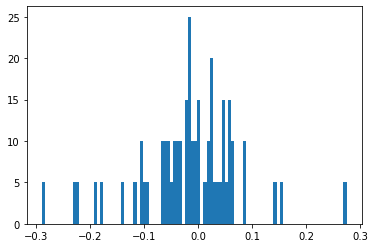

In [7]:
obs,_,_,_ = self.step()
plt.hist(obs[:,-64:-1].ravel(),bins=100)
plt.show()

In [3]:
%timeit _ =self.step()

1.91 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%timeit _ =self.step()

2.02 ms ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [3]:
obs.shape

(8, 128)

In [4]:
5*192

960

In [5]:
8*128

1024

In [ ]:
import socket

In [ ]:
sock = socket.socket(socket.AF_INET,socket.SOCK_DGRAM) # UDP
sock.bind(("localhost",32000)) #Bind the socket to the port
sock.settimeout(10)
data = sock.recv(10240)

In [1]:
import numpy as np

In [12]:
a = [1,2,3,4,5]

In [13]:
a.append(6)

In [15]:
np.average(a[-3:])

5.0